# LSTM 

## Outline
1. [Imports](#imports)
2. [Data](#data)
3. [Model](#model)
5. [Train](#train)
6. [Predict](#predict)

<a name=imports></a>
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import os
import datetime

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import preprocessing

<a name=data></a>
## Data

### Ingestion
Load in the dataset as pandas dataframe.

In [2]:
# Check preprocessing.py for implementation
(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df) = preprocessing.ingestion()

Parent Directory /covid19-prediction/models
Path: /covid19-prediction/models/../cleaned_datasets/india/daily_cases_india.csv
Exists: True
India Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-01-30        NaN     NaN        NaN
1  2020-01-31        0.0     0.0        0.0
2  2020-02-01        0.0     0.0        0.0
3  2020-02-02        1.0     0.0        0.0
4  2020-02-03        1.0     0.0        0.0 

India Vacc:
          Date  Total_Doses
0  2021-01-15          NaN
1  2021-01-16          NaN
2  2021-01-17      33120.0
3  2021-01-18     229748.0
4  2021-01-19     220786.0 

USA Cases:
          Date  Confirmed  Deaths  Recovered
0  2020-04-12        NaN     NaN        NaN
1  2020-04-13    25255.0  1542.0    11785.0
2  2020-04-14    26694.0  2327.0     6484.0
3  2020-04-15    29318.0  2474.0     6093.0
4  2020-04-16    31235.0  4607.0     5234.0 

USA Vacc:
          Date  Total_Doses
0  2020-12-20          NaN
1  2020-12-21      57909.0
2  2020-12-22     196954.0
3  2020-

### Pre-Processing
Filter out unnecessary columns. 

#### Multivariate

In [3]:
# Check preprocessing.py for implementation
# Number of Null in India - 563
# Number of Null in USA - 261
(india_multi, usa_multi) = preprocessing.multivariate(india_cases_df, india_vacc_df, usa_cases_df, usa_vacc_df)

India:
          Date  Confirmed  Total_Doses
0  2020-01-30        NaN          NaN
1  2020-01-31        0.0          NaN
2  2020-02-01        0.0          NaN
3  2020-02-02        1.0          NaN
4  2020-02-03        1.0          NaN
USA:
          Date  Confirmed  Total_Doses
0  2020-04-12        NaN          NaN
1  2020-04-13    25255.0          NaN
2  2020-04-14    26694.0          NaN
3  2020-04-15    29318.0          NaN
4  2020-04-16    31235.0          NaN


#### Univariate 

In [4]:
# Check preprocessing.py for implementation
# Number of Null in India - 0
# Number of Null in USA - 0
(india_cases_uni, usa_cases_uni) = preprocessing.univariate(india_cases_df, usa_cases_df)

India Cases:
    Confirmed
1        0.0
2        0.0
3        1.0
4        1.0
5        0.0 

USA Cases:
    Confirmed
1    25255.0
2    26694.0
3    29318.0
4    31235.0
5    32175.0 



### Drop Null
Merging the vaccination and #cases datasets together for multivariate time series produces null values. Dropping the nuWe solve this by dropping the null values.ll values ensures that we take an inner join.

In [5]:
(india_multi, usa_multi) = preprocessing.dropNull(india_multi, usa_multi)

India:
            Date  Confirmed  Total_Doses
353  2021-01-17    13788.0      33120.0
354  2021-01-18    10050.0     229748.0
355  2021-01-19    13816.0     220786.0
356  2021-01-20    15244.0     131649.0
357  2021-01-21    14545.0     237050.0
USA:
            Date  Confirmed  Total_Doses
253  2020-12-21   189716.0      57909.0
254  2020-12-22   201947.0     196954.0
255  2020-12-23   225777.0     196954.0
256  2020-12-24   204900.0     468280.0
257  2020-12-25   108685.0     234140.0


### Normalize
Perform a Z-score normalization.

In [6]:
# Check preprocessing.py for implementation
(india_uni_norm, usa_uni_norm, india_multi_norm, usa_multi_norm,india_cases_mean,india_cases_std,usa_cases_mean,usa_cases_std,india_multi_mean,india_multi_std,
usa_multi_mean, usa_multi_std) = preprocessing.normalize(india_cases_uni, 
                                                                                           usa_cases_uni, 
                                                                                           india_multi, 
                                                                                           usa_multi)

India Cases univariate:
    Confirmed
1  -0.662416
2  -0.662416
3  -0.662403
4  -0.662403
5  -0.662416 

USA Cases univariate:
    Confirmed
1  -0.596456
2  -0.584433
3  -0.562508
4  -0.546491
5  -0.538637 

India Cases multivariate:
      Confirmed  Total_Doses
353  -0.564210    -1.306870
354  -0.602772    -1.247747
355  -0.563921    -1.250442
356  -0.549190    -1.277244
357  -0.556401    -1.245551 

USA Cases multivariate:
      Confirmed  Total_Doses
253   0.524077    -0.977570
254   0.609261    -0.926634
255   0.775228    -0.926634
256   0.629828    -0.827240
257  -0.040273    -0.913012 



### Create Splits
Break the dataset into train and test. The current split is 80:20.

In [7]:
# Create train test splits
(india_uni_train, india_uni_test, usa_uni_train, usa_uni_test) = preprocessing.split(india_uni_norm, usa_uni_norm, 0.2)
(india_multi_train, india_multi_test, 
 usa_multi_train, usa_multi_test) = preprocessing.split(india_multi_norm, usa_multi_norm, 0.2)

India:
      Confirmed
1    -0.662416
2    -0.662416
3    -0.662403
4    -0.662403
5    -0.662416
..         ...
564  -0.332037
565  -0.200599
566  -0.184543
567  -0.182312
568  -0.210064

[568 rows x 1 columns] 

USA:
      Confirmed
1    -0.596456
2    -0.584433
3    -0.562508
4    -0.546491
5    -0.538637
..         ...
507   0.882933
508   0.655423
509   1.161010
510  -0.188293
511  -0.412010

[511 rows x 1 columns] 

India:
      Confirmed  Total_Doses
353  -0.564210    -1.306870
354  -0.602772    -1.247747
355  -0.563921    -1.250442
356  -0.549190    -1.277244
357  -0.556401    -1.245551
..         ...          ...
637  -0.558433     0.454255
638  -0.558794     1.464557
639  -0.574093     0.722069
640  -0.577353    -0.071408
641  -0.598924     0.193515

[278 rows x 2 columns] 

USA:
      Confirmed  Total_Doses
253   0.524077    -0.977570
254   0.609261    -0.926634
255   0.775228    -0.926634
256   0.629828    -0.827240
257  -0.040273    -0.913012
..         ...          ...
55

### Data Transformation
Simple conversion from pandas dataframe to numpy array by extracting the values.

In [8]:
# Univariate
india_uni_train_np, india_uni_test_np = india_uni_train.values,  india_uni_test.values
usa_uni_train_np, usa_uni_test_np = usa_uni_train.values, usa_uni_test.values
# Multivariate
india_multi_train_np, india_multi_test_np = india_multi_train.values,  india_multi_test.values
usa_multi_train_np, usa_multi_test_np = usa_multi_train.values, usa_multi_test.values

In [9]:
print(india_uni_train_np.shape, india_uni_test_np.shape)
print(india_multi_train_np.shape, india_multi_test_np.shape)

(568, 1) (143, 1)
(278, 2) (70, 2)


### Reshape
Converts the exiting train data set to match the input parameters of an LSTM (Samples, Time Steps, Features). The `lstm_data_transform()` method takes in 3 arguments: X data, y data and number of features.

We will be performing autoregression on the univariate data, therefore the X and y values are the same. As for the multivariate data, we will be using the confirmed column (index 0) as the y value.

In [10]:
india_uni_train_np

array([[-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62403204e-01],
       [-6.62403204e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62416332e-01],
       [-6.62390076e-01],
       [-6.62416332e-01],
       [-6.62114388e-01],
       [-6.62390076e-01],
       [-6.62403204e-01],
       [-6.62376948e-01],
       [-6.62350692e-01],
       [-6.6

In [11]:
timesteps = 14

In [12]:
# Univariate
india_uni_train_X, india_uni_train_y = preprocessing.lstm_data_transform(india_uni_train_np, india_uni_train_np,
                                                                         timesteps)
usa_uni_train_X, usa_uni_train_y = preprocessing.lstm_data_transform(usa_uni_train_np, usa_uni_train_np,
                                                                     timesteps)
# Multivariate
india_multi_train_X, india_multi_train_y = preprocessing.lstm_data_transform(india_multi_train_np, india_multi_train_np, timesteps)
usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np, timesteps)
# usa_multi_train_X, usa_multi_train_y = preprocessing.lstm_data_transform(usa_multi_train_np, usa_multi_train_np[:,0], timesteps)

In [13]:
print("Univariate India shape:",india_uni_train_X.shape, india_uni_train_y.shape)
print("Multivariate India shape:",india_multi_train_X.shape, india_multi_train_y.shape)

Univariate India shape: (554, 14, 1) (554, 1)
Multivariate India shape: (264, 14, 2) (264, 2)


The univariate array shape for the India dataset has 566 samples, 3 as the time step, and 1 feature for the X values. The y values is just the 566 samples.

Similarly, the multivariate array shape for the India dataset has 276 samples, 3 as the time step, and 2 features for the X values. The y values is just the 276 samples of the 0th column (Confirmed cases).

<a name=model></a>
## Model
We will define 4 models in total. One for the univariate data and another for the multivariate for each country.

In [14]:
import LSTMmodels
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf

In [15]:
univariate_model_ind = LSTMmodels.build_lstm(time_steps=india_uni_train_X.shape[1],
                                             features=india_uni_train_X.shape[2])
univariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_uni_train_X.shape[1],
                                             features=usa_uni_train_X.shape[2])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
______________________________

In [16]:
multivariate_model_ind = LSTMmodels.build_lstm(time_steps=india_multi_train_X.shape[1],
                                               features=india_multi_train_X.shape[2], outputs=2)
multivariate_model_usa = LSTMmodels.build_lstm(time_steps=usa_multi_train_X.shape[1],
                                               features=usa_multi_train_X.shape[2], outputs=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_4 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 42        
Total params: 43,262
Trainable params: 43,262
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100)               41200     
_________________________________________________________________
dense_6 (Dense)              (None, 20)                2020      
____________________________

<a name=train></a>
## Train 

In [17]:
# Get the path of the current working directory
curPath = os.getcwd()
# Appened the parent directory to the current path to step out of the current folder
parentDir = os.path.abspath(os.path.join(curPath, os.pardir))
# Tensorboard callback
logdir = os.path.join(parentDir+"/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [18]:
def train_models(model,train_X,train_y,test_X,test_y):
    model.fit(train_X,train_y,
              validation_data=(test_X,test_y),
              epochs=300,
              callbacks=[tensorboard_callback])
    return model
#     model.save(save_name)

In [19]:
# Train the model on univariate India dataset 
univariate_model_ind = LSTMmodels.train_model(univariate_model_ind,india_uni_train_X,india_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
18/18 [==============================] - 2s 32ms/step - loss: 0.4652 - mae: 0.4652
Epoch 2/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1875 - mae: 0.1875
Epoch 3/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1504 - mae: 0.1504
Epoch 4/300
18/18 [==============================] - 0s 12ms/step - loss: 0.1374 - mae: 0.1374
Epoch 5/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1301 - mae: 0.1301
Epoch 6/300
18/18 [==============================] - 0s 13ms/step - loss: 0.1122 - mae: 0.1122
Epoch 7/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0966 - mae: 0.0966
Epoch 8/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0867 - mae: 0.0867
Epoch 9/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0927 - mae: 0.0927
Epoch 10/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0869 - mae: 0.0869
Epoch 11/300
18/18 [=============================

18/18 [==============================] - 0s 12ms/step - loss: 0.0537 - mae: 0.0537
Epoch 87/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0543 - mae: 0.0543
Epoch 88/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0576 - mae: 0.0576
Epoch 89/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0536 - mae: 0.0536
Epoch 90/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0545 - mae: 0.0545
Epoch 91/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0597 - mae: 0.0597
Epoch 92/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0569 - mae: 0.0569
Epoch 93/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0512 - mae: 0.0512
Epoch 94/300
18/18 [==============================] - 0s 14ms/step - loss: 0.0534 - mae: 0.0534
Epoch 95/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0593 - mae: 0.0593
Epoch 96/300
18/18 [==============================] -

18/18 [==============================] - 0s 12ms/step - loss: 0.0491 - mae: 0.0491
Epoch 171/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0455 - mae: 0.0455
Epoch 172/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0441 - mae: 0.0441
Epoch 173/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0460 - mae: 0.0460
Epoch 174/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0525 - mae: 0.0525
Epoch 175/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0495 - mae: 0.0495
Epoch 176/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0448 - mae: 0.0448
Epoch 177/300
18/18 [==============================] - 0s 12ms/step - loss: 0.0453 - mae: 0.0453
Epoch 178/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0502 - mae: 0.0502
Epoch 179/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0526 - mae: 0.0526
Epoch 180/300
18/18 [=======================

18/18 [==============================] - 0s 12ms/step - loss: 0.0350 - mae: 0.0350
Epoch 255/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0366 - mae: 0.0366
Epoch 256/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0379 - mae: 0.0379
Epoch 257/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0376 - mae: 0.0376
Epoch 258/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0391 - mae: 0.0391
Epoch 259/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0373 - mae: 0.0373
Epoch 260/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0357 - mae: 0.0357
Epoch 261/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0371 - mae: 0.0371
Epoch 262/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0417 - mae: 0.0417
Epoch 263/300
18/18 [==============================] - 0s 13ms/step - loss: 0.0391 - mae: 0.0391
Epoch 264/300
18/18 [=======================

In [20]:
# Train the model on univariate USA dataset 
univariate_model_usa = LSTMmodels.train_model(univariate_model_usa,usa_uni_train_X,usa_uni_train_y,
                                              tensorboard_callback)

Epoch 1/300
16/16 [==============================] - 1s 33ms/step - loss: 0.3694 - mae: 0.3694
Epoch 2/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1533 - mae: 0.1533
Epoch 3/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1392 - mae: 0.1392
Epoch 4/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1333 - mae: 0.1333
Epoch 5/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1316 - mae: 0.1316
Epoch 6/300
16/16 [==============================] - 0s 12ms/step - loss: 0.1309 - mae: 0.1309
Epoch 7/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1378 - mae: 0.1378
Epoch 8/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1315 - mae: 0.1315
Epoch 9/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1341 - mae: 0.1341
Epoch 10/300
16/16 [==============================] - 0s 13ms/step - loss: 0.1308 - mae: 0.1308
Epoch 11/300
16/16 [=============================

16/16 [==============================] - 0s 13ms/step - loss: 0.0697 - mae: 0.0697
Epoch 87/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0690 - mae: 0.0690
Epoch 88/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0708 - mae: 0.0708
Epoch 89/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0679 - mae: 0.0679
Epoch 90/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0663 - mae: 0.0663
Epoch 91/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0672 - mae: 0.0672
Epoch 92/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0677 - mae: 0.0677
Epoch 93/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0662 - mae: 0.0662
Epoch 94/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0652 - mae: 0.0652
Epoch 95/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0638 - mae: 0.0638
Epoch 96/300
16/16 [==============================] -

16/16 [==============================] - 0s 13ms/step - loss: 0.0587 - mae: 0.0587
Epoch 171/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0504 - mae: 0.0504
Epoch 172/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0505 - mae: 0.0505
Epoch 173/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0530 - mae: 0.0530
Epoch 174/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0513 - mae: 0.0513
Epoch 175/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0509 - mae: 0.0509
Epoch 176/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0561 - mae: 0.0561
Epoch 177/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0512 - mae: 0.0512
Epoch 178/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0542 - mae: 0.0542
Epoch 179/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0533 - mae: 0.0533
Epoch 180/300
16/16 [=======================

16/16 [==============================] - 0s 13ms/step - loss: 0.0454 - mae: 0.0454
Epoch 255/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0454 - mae: 0.0454
Epoch 256/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0457 - mae: 0.0457
Epoch 257/300
16/16 [==============================] - 0s 14ms/step - loss: 0.0440 - mae: 0.0440
Epoch 258/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0449 - mae: 0.0449
Epoch 259/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0429 - mae: 0.0429
Epoch 260/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0428 - mae: 0.0428
Epoch 261/300
16/16 [==============================] - 0s 13ms/step - loss: 0.0472 - mae: 0.0472
Epoch 262/300
16/16 [==============================] - 0s 11ms/step - loss: 0.0470 - mae: 0.0470
Epoch 263/300
16/16 [==============================] - 0s 12ms/step - loss: 0.0435 - mae: 0.0435
Epoch 264/300
16/16 [=======================

In [21]:
# Train the model on multivariate India dataset
multivariate_model_ind = LSTMmodels.train_model(multivariate_model_ind,india_multi_train_X,india_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
9/9 [==============================] - 1s 50ms/step - loss: 0.6814 - mae: 0.6814
Epoch 2/300
9/9 [==============================] - 0s 13ms/step - loss: 0.4718 - mae: 0.4718
Epoch 3/300
9/9 [==============================] - 0s 12ms/step - loss: 0.3538 - mae: 0.3538
Epoch 4/300
9/9 [==============================] - 0s 12ms/step - loss: 0.3178 - mae: 0.3178
Epoch 5/300
9/9 [==============================] - 0s 13ms/step - loss: 0.3074 - mae: 0.3074
Epoch 6/300
9/9 [==============================] - 0s 12ms/step - loss: 0.2947 - mae: 0.2947
Epoch 7/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2916 - mae: 0.2916
Epoch 8/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2846 - mae: 0.2846
Epoch 9/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2825 - mae: 0.2825
Epoch 10/300
9/9 [==============================] - 0s 12ms/step - loss: 0.2759 - mae: 0.2759
Epoch 11/300
9/9 [==============================] - 0s 13ms/step - lo

9/9 [==============================] - 0s 14ms/step - loss: 0.2183 - mae: 0.2183
Epoch 89/300
9/9 [==============================] - 0s 12ms/step - loss: 0.2200 - mae: 0.2200
Epoch 90/300
9/9 [==============================] - 0s 12ms/step - loss: 0.2223 - mae: 0.2223
Epoch 91/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2191 - mae: 0.2191
Epoch 92/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2202 - mae: 0.2202
Epoch 93/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2188 - mae: 0.2188
Epoch 94/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2169 - mae: 0.2169
Epoch 95/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2146 - mae: 0.2146
Epoch 96/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2170 - mae: 0.2170
Epoch 97/300
9/9 [==============================] - 0s 13ms/step - loss: 0.2209 - mae: 0.2209
Epoch 98/300
9/9 [==============================] - 0s 13ms/step - loss: 

9/9 [==============================] - 0s 13ms/step - loss: 0.1901 - mae: 0.1901
Epoch 175/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1862 - mae: 0.1862
Epoch 176/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1839 - mae: 0.1839
Epoch 177/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1825 - mae: 0.1825
Epoch 178/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1870 - mae: 0.1870
Epoch 179/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1895 - mae: 0.1895
Epoch 180/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1880 - mae: 0.1880
Epoch 181/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1927 - mae: 0.1927
Epoch 182/300
9/9 [==============================] - 0s 14ms/step - loss: 0.1983 - mae: 0.1983
Epoch 183/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1968 - mae: 0.1968
Epoch 184/300
9/9 [==============================] - 0s 14ms/ste

9/9 [==============================] - 0s 12ms/step - loss: 0.1388 - mae: 0.1388
Epoch 261/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1439 - mae: 0.1439
Epoch 262/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1334 - mae: 0.1334
Epoch 263/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1448 - mae: 0.1448
Epoch 264/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1469 - mae: 0.1469
Epoch 265/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1378 - mae: 0.1378
Epoch 266/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1284 - mae: 0.1284
Epoch 267/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1286 - mae: 0.1286
Epoch 268/300
9/9 [==============================] - 0s 13ms/step - loss: 0.1391 - mae: 0.1391
Epoch 269/300
9/9 [==============================] - 0s 12ms/step - loss: 0.1331 - mae: 0.1331
Epoch 270/300
9/9 [==============================] - 0s 13ms/ste

In [22]:
# Train the model on multivariate USA dataset
multivariate_model_usa = LSTMmodels.train_model(multivariate_model_usa,usa_multi_train_X,usa_multi_train_y,
                                                tensorboard_callback)

Epoch 1/300
10/10 [==============================] - 1s 46ms/step - loss: 0.4901 - mae: 0.4901
Epoch 2/300
10/10 [==============================] - 0s 13ms/step - loss: 0.3865 - mae: 0.3865
Epoch 3/300
10/10 [==============================] - 0s 13ms/step - loss: 0.3292 - mae: 0.3292
Epoch 4/300
10/10 [==============================] - 0s 14ms/step - loss: 0.3070 - mae: 0.3070
Epoch 5/300
10/10 [==============================] - 0s 13ms/step - loss: 0.2920 - mae: 0.2920
Epoch 6/300
10/10 [==============================] - 0s 14ms/step - loss: 0.2843 - mae: 0.2843
Epoch 7/300
10/10 [==============================] - 0s 14ms/step - loss: 0.2814 - mae: 0.2814
Epoch 8/300
10/10 [==============================] - 0s 14ms/step - loss: 0.2847 - mae: 0.2847
Epoch 9/300
10/10 [==============================] - 0s 12ms/step - loss: 0.2816 - mae: 0.2816
Epoch 10/300
10/10 [==============================] - 0s 12ms/step - loss: 0.2810 - mae: 0.2810
Epoch 11/300
10/10 [=============================

10/10 [==============================] - 0s 13ms/step - loss: 0.1831 - mae: 0.1831
Epoch 87/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1818 - mae: 0.1818
Epoch 88/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1836 - mae: 0.1836
Epoch 89/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1827 - mae: 0.1827
Epoch 90/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1854 - mae: 0.1854
Epoch 91/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1774 - mae: 0.1774
Epoch 92/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1799 - mae: 0.1799
Epoch 93/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1792 - mae: 0.1792
Epoch 94/300
10/10 [==============================] - 0s 14ms/step - loss: 0.1773 - mae: 0.1773
Epoch 95/300
10/10 [==============================] - 0s 12ms/step - loss: 0.1716 - mae: 0.1716
Epoch 96/300
10/10 [==============================] -

10/10 [==============================] - 0s 13ms/step - loss: 0.1452 - mae: 0.1452
Epoch 171/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1440 - mae: 0.1440
Epoch 172/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1408 - mae: 0.1408
Epoch 173/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1421 - mae: 0.1421
Epoch 174/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1432 - mae: 0.1432
Epoch 175/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1368 - mae: 0.1368
Epoch 176/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1354 - mae: 0.1354
Epoch 177/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1338 - mae: 0.1338
Epoch 178/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1338 - mae: 0.1338
Epoch 179/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1371 - mae: 0.1371
Epoch 180/300
10/10 [=======================

10/10 [==============================] - 0s 13ms/step - loss: 0.1256 - mae: 0.1256
Epoch 255/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1287 - mae: 0.1287
Epoch 256/300
10/10 [==============================] - 0s 14ms/step - loss: 0.1282 - mae: 0.1282
Epoch 257/300
10/10 [==============================] - 0s 14ms/step - loss: 0.1225 - mae: 0.1225
Epoch 258/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1207 - mae: 0.1207
Epoch 259/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1186 - mae: 0.1186
Epoch 260/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1173 - mae: 0.1173
Epoch 261/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1191 - mae: 0.1191
Epoch 262/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1122 - mae: 0.1122
Epoch 263/300
10/10 [==============================] - 0s 13ms/step - loss: 0.1132 - mae: 0.1132
Epoch 264/300
10/10 [=======================

<a name=predict></a>
## Predict
There are 2 different types of prediction methods. 
1. Long-term predictions

This type of prediction uses a sliding window to continue to predict into the future by continuing to use the forecasted values.

2. Rolling short-term predictions

This prediction method continues to train the LSTM model every 14 iterations. Unlike the long-term predictions, this model forecasts one day at a time.

In [23]:
import evaluate

In [24]:
india_uni_test_np.shape

(143, 1)

#### Long-Term 

In [25]:
# Univariate Long-Term
yhat_uni_india = evaluate.make_predictions(univariate_model_ind,india_uni_test_np,timesteps,india_uni_test_np.shape[1])
yhat_uni_usa = evaluate.make_predictions(univariate_model_usa,usa_uni_test_np,timesteps,usa_uni_test_np.shape[1])

In [26]:
# Multivariate Long-Term 
yhat_multi_india_long = evaluate.make_predictions(multivariate_model_ind,india_multi_test_np,timesteps,india_multi_test_np.shape[1])
yhat_multi_usa_long = evaluate.make_predictions(multivariate_model_usa,usa_multi_test_np,timesteps,usa_multi_test_np.shape[1])

#### Rolling Short-Term 

In [27]:
# Univariate Rolling Short-Term
yhat_uni_india_short, y_uni_india_short, univariate_model_ind = evaluate.make_predictions_short(univariate_model_ind,
                                                                                                india_uni_train_np,
                                                                                                india_uni_test_np,timesteps,
                                                                                                india_uni_test_np.shape[1],
                                                                                               tensorboard_callback)
yhat_uni_usa_short, y_uni_usa_short, univariate_model_usa = evaluate.make_predictions_short(univariate_model_usa, 
                                                                                            usa_uni_train_np,
                                                                                            usa_uni_test_np,timesteps,
                                                                                            usa_uni_test_np.shape[1],
                                                                                           tensorboard_callback)

y_data []
-0.25613042391601215
Epoch 1/10
18/18 [==============================] - 1s 31ms/step - loss: 0.0333 - mae: 0.0333
Epoch 2/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0359 - mae: 0.0359
Epoch 3/10
18/18 [==============================] - 0s 14ms/step - loss: 0.0324 - mae: 0.0324
Epoch 4/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0392 - mae: 0.0392
Epoch 5/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0386 - mae: 0.0386
Epoch 6/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0324 - mae: 0.0324
Epoch 7/10
18/18 [==============================] - 0s 13ms/step - loss: 0.0342 - mae: 0.0342
Epoch 8/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0349 - mae: 0.0349
Epoch 9/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0325 - mae: 0.0325
Epoch 10/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0355 - mae: 0.0355
[[-0.14950466]
 [-0.19638481

-0.25842782710770135
Epoch 1/10
19/19 [==============================] - 1s 28ms/step - loss: 0.0340 - mae: 0.0340
Epoch 2/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0335 - mae: 0.0335
Epoch 3/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0364 - mae: 0.0364
Epoch 4/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0349 - mae: 0.0349
Epoch 5/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0313 - mae: 0.0313
Epoch 6/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0336 - mae: 0.0336
Epoch 7/10
19/19 [==============================] - 0s 11ms/step - loss: 0.0372 - mae: 0.0372
Epoch 8/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0344 - mae: 0.0344
Epoch 9/10
19/19 [==============================] - 0s 12ms/step - loss: 0.0369 - mae: 0.0369
Epoch 10/10
19/19 [==============================] - 0s 13ms/step - loss: 0.0363 - mae: 0.0363
[[-0.1009835 ]
 [-0.15110628]
 [-0.252

20/20 [==============================] - 1s 27ms/step - loss: 0.0387 - mae: 0.0387
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0342 - mae: 0.0342
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0385 - mae: 0.0385
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0379 - mae: 0.0379
Epoch 5/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0329 - mae: 0.0329
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0314 - mae: 0.0314
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0334 - mae: 0.0334
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0421 - mae: 0.0421
Epoch 9/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0347 - mae: 0.0347
Epoch 10/10
20/20 [==============================] - 0s 12ms/step - loss: 0.0335 - mae: 0.0335
[[-0.36254614]
 [-0.38936668]
 [-0.42156971]
 [-0.41517636]
 [-0.36794

-0.5144504387895462
Epoch 1/10
20/20 [==============================] - 1s 26ms/step - loss: 0.0307 - mae: 0.0307
Epoch 2/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0313 - mae: 0.0313
Epoch 3/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0317 - mae: 0.0317
Epoch 4/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0295 - mae: 0.0295
Epoch 5/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0288 - mae: 0.0288
Epoch 6/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0298 - mae: 0.0298
Epoch 7/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0325 - mae: 0.0325
Epoch 8/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0337 - mae: 0.0337
Epoch 9/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0300 - mae: 0.0300
Epoch 10/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0290 - mae: 0.0290
[[-0.49398386]
 [-0.49813231]
 [-0.5255

-0.5590069326900785
Epoch 1/10
21/21 [==============================] - 1s 26ms/step - loss: 0.0308 - mae: 0.0308
Epoch 2/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0302 - mae: 0.0302
Epoch 3/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0274 - mae: 0.0274
Epoch 4/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0283 - mae: 0.0283
Epoch 5/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0311 - mae: 0.0311
Epoch 6/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0299 - mae: 0.0299
Epoch 7/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0283 - mae: 0.0283
Epoch 8/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0275 - mae: 0.0275
Epoch 9/10
21/21 [==============================] - 0s 13ms/step - loss: 0.0285 - mae: 0.0285
Epoch 10/10
21/21 [==============================] - 0s 12ms/step - loss: 0.0306 - mae: 0.0306
[[-0.5472311 ]
 [-0.55333563]
 [-0.5706

1.4332354750516074
Epoch 1/10
22/22 [==============================] - 1s 24ms/step - loss: 0.0320 - mae: 0.0320
Epoch 2/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0297 - mae: 0.0297
Epoch 3/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0293 - mae: 0.0293
Epoch 4/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0312 - mae: 0.0312
Epoch 5/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0309 - mae: 0.0309
Epoch 6/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0303 - mae: 0.0303
Epoch 7/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0317 - mae: 0.0317
Epoch 8/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0302 - mae: 0.0302
Epoch 9/10
22/22 [==============================] - 0s 12ms/step - loss: 0.0302 - mae: 0.0302
Epoch 10/10
22/22 [==============================] - 0s 13ms/step - loss: 0.0306 - mae: 0.0306
[[-0.57069087]
 [-0.57667725]
 [-0.57894

0.1231476811187108
[[ 0.41400055]
 [ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]]
0.22374718053872117
[[ 0.61785658]
 [ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]
 [ 0.12314768]]
0.11124953434345376
[[ 0.49189832]
 [ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]
 [ 0.12314768]
 [ 0.22374718]]
0.46989009195185116
[[ 0.93776132]
 [-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.20905832]
 [ 0.30489522]
 [ 0.24927305]
 [ 0.67067132]
 [-0.35603681]
 [-0.39279239]
 [ 0.56840073]
 [ 0.12314768]
 [ 0.22374718]
 [ 0.11124953]]
-0.43159505683749744
[[-0.27036848]
 [-0.45486496]
 [ 0.76676724]
 [ 0.209058

-0.23336223925113983
[[ 0.08130364]
 [ 0.20835646]
 [-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]]
0.03559937921481807
[[ 0.20835646]
 [-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]]
-0.15955028095576015
[[-0.08575503]
 [ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]
 [ 0.03559938]]
-0.02557915357200218
[[ 0.10992102]
 [-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.13111672]
 [-0.04331775]
 [-0.14823701]
 [-0.01242769]
 [-0.55563992]
 [-0.65520335]
 [ 0.14757899]
 [-0.23336224]
 [ 0.03559938]
 [-0.15955028]]
-0.5352108701520779
[[-0.50366073]
 [-0.54065862]
 [ 0.04644474]
 [-0.131

[[-0.13641407]
 [-0.01362252]
 [-0.32985086]
 [ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]]
0.12512792043453658
[[-0.01362252]
 [-0.32985086]
 [ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]]
-0.5170377878232969
[[-0.32985086]
 [ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]]
-0.3725972939301309
[[ 0.40319697]
 [-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 [ 0.11435776]
 [ 0.24414281]
 [-0.4424822 ]
 [-0.48224574]
 [ 0.42619114]
 [-0.03315754]
 [ 0.12512792]
 [-0.51703779]]
-0.5944676517041305
[[-0.45189878]
 [-0.54771896]
 [ 0.33591061]
 [-0.07309654]
 [ 0.12602195]
 

1.211878243695637
[[ 0.4530873 ]
 [ 0.2174806 ]
 [ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]]
1.4420873307404978
[[ 0.2174806 ]
 [ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]]
1.0262287189769317
[[ 0.61914332]
 [-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]
 [ 1.44208733]]
-0.33076160509325453
[[-0.34930233]
 [-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]
 [ 0.37655147]
 [ 0.80431658]
 [-0.16887495]
 [-0.08172771]
 [ 1.2152622 ]
 [ 0.6880005 ]
 [ 1.21187824]
 [ 1.44208733]
 [ 1.02622872]]
0.7179463991595976
[[-0.38607462]
 [ 0.77925026]
 [ 0.14376891]
 [ 0.39652097]


In [28]:
# Reshaping the data to standard dim 1
yhat_uni_india_short = np.concatenate(yhat_uni_india_short).flatten()
yhat_uni_india_short

array([-0.1984474 , -0.2853249 , -0.3705668 , -0.2946532 , -0.21138796,
       -0.12143194, -0.07882583, -0.07958329, -0.10057301, -0.14305927,
        0.00398587,  0.02286692,  0.05935393, -0.02392451, -0.22137362,
       -0.33514616, -0.30413237, -0.15341625, -0.10496321, -0.10012382,
       -0.11404215, -0.15983649, -0.24834712, -0.36022386, -0.27573502,
       -0.26569706, -0.27545553, -0.27066043, -0.26009244, -0.2801832 ,
       -0.3349382 , -0.3121455 , -0.28318018, -0.2644902 , -0.24804085,
       -0.2982429 , -0.34248805, -0.3735621 , -0.3827013 , -0.3869429 ,
       -0.3620774 , -0.34252474, -0.33761   , -0.3611506 , -0.40245336,
       -0.39662597, -0.37715742, -0.35422334, -0.33836326, -0.3659013 ,
       -0.39807117, -0.42467707, -0.42487016, -0.41208827, -0.39706713,
       -0.41212812, -0.47046033, -0.49083877, -0.49896935, -0.4930861 ,
       -0.47441292, -0.46091136, -0.46752077, -0.47711796, -0.47661707,
       -0.4755473 , -0.4668564 , -0.46169913, -0.46331677, -0.47

In [29]:
# Reshaping the data to standard dim 1
yhat_uni_usa_short = np.concatenate(yhat_uni_usa_short).flatten()
yhat_uni_usa_short

array([ 1.35608768e+00,  9.72364724e-01,  4.40114915e-01,  4.85631168e-01,
        9.00336087e-01, -1.83700457e-01, -3.51383597e-01,  1.31440306e+00,
        6.41623616e-01,  8.72376859e-01,  7.85253763e-01,  1.27321565e+00,
        1.61475480e-01, -3.48576307e-01,  8.94445062e-01,  7.55952179e-01,
        8.57484400e-01,  7.87918270e-01,  9.87522721e-01,  2.36742526e-01,
       -4.47589844e-01,  1.07733715e+00,  5.08947968e-01,  6.30521238e-01,
        6.18637800e-01,  8.59552562e-01,  1.37952954e-01, -2.44118154e-01,
        5.50628424e-01, -6.67523220e-02,  1.98573116e-02,  2.33700871e-03,
        2.61145383e-01, -1.67339861e-01, -7.88957030e-02,  4.40300286e-01,
       -1.04041368e-01, -1.93419442e-01, -1.64091438e-01,  8.30944628e-02,
       -2.86370605e-01, -2.74592906e-01, -3.17360237e-02,  1.15632936e-01,
        1.96730003e-01,  1.83038577e-01,  1.42569318e-01, -5.31232715e-01,
       -5.50995409e-01, -2.36177102e-01, -1.62667036e-01, -2.29091458e-02,
        7.07693025e-02,  

In [30]:
india_multi_test_np.shape

(70, 2)

In [31]:
# Multivariate Rolling Short-Term
yhat_multi_india, y_multi_india_short, multivariate_model_ind = evaluate.make_predictions_short(multivariate_model_ind, india_multi_train_np,india_multi_test_np,timesteps,
                                                                                                india_multi_test_np.shape[1],
                                                                                               tensorboard_callback, india_multi_test_np.shape[0])
yhat_multi_usa, y_multi_india_short, multivariate_model_usa = evaluate.make_predictions_short(multivariate_model_usa,usa_multi_train_np,usa_multi_test_np,
                                                                      timesteps,usa_multi_test_np.shape[1],
                                                                     tensorboard_callback, usa_multi_test_np.shape[0])

y_data []
-0.6961158008333377
Epoch 1/10
9/9 [==============================] - 0s 44ms/step - loss: 0.1144 - mae: 0.1144
Epoch 2/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1101 - mae: 0.1101
Epoch 3/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1171 - mae: 0.1171
Epoch 4/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1131 - mae: 0.1131
Epoch 5/10
9/9 [==============================] - 0s 12ms/step - loss: 0.1185 - mae: 0.1185
Epoch 6/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1194 - mae: 0.1194
Epoch 7/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1133 - mae: 0.1133
Epoch 8/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1095 - mae: 0.1095
Epoch 9/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1134 - mae: 0.1134
Epoch 10/10
9/9 [==============================] - 0s 13ms/step - loss: 0.1091 - mae: 0.1091
[[-0.55559628  1.13626989]
 [-0.51607476  1.77603

0.129075610880924
[[-0.59370447 -1.11046767]
 [-0.59476704 -0.60003516]
 [-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.01561139]
 [-0.60092584 -0.20155596]
 [-0.61499719 -0.08640154]
 [-0.60125596  0.69979557]
 [-0.58349139  0.88374719]
 [-0.5918785   1.02256989]]
1.7169374777621258
[[-0.59476704 -0.60003516]
 [-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.01561139]
 [-0.60092584 -0.20155596]
 [-0.61499719 -0.08640154]
 [-0.60125596  0.69979557]
 [-0.58349139  0.88374719]
 [-0.5918785   1.02256989]
 [-0.60017275  0.12907561]]
-0.0021586513513274876
[[-0.58804085 -0.42534982]
 [-0.60198841  0.21479608]
 [-0.58816465 -0.14051078]
 [-0.57140076  0.3845279 ]
 [-0.5773326   0.17735122]
 [-0.58420321  1.28342944]
 [-0.59017632  1.015

0.1729263070294695
[[-0.62826388  1.02436499]
 [-0.610685    1.11988876]
 [-0.61237686  1.63652474]
 [-0.59762464  0.11426467]
 [-0.62064017  2.36040476]
 [-0.61593597 -0.79514768]
 [-0.62073302  1.90101989]
 [-0.63434014  0.27600183]
 [-0.61407904  1.25799492]
 [-0.60571257  1.22759486]
 [-0.61137619  1.79505176]
 [-0.61770004  0.44568314]
 [-0.70645066  2.31493426]
 [-0.52900101  0.17377064]]
1.162081766526565
[[-0.610685    1.11988876]
 [-0.61237686  1.63652474]
 [-0.59762464  0.11426467]
 [-0.62064017  2.36040476]
 [-0.61593597 -0.79514768]
 [-0.62073302  1.90101989]
 [-0.63434014  0.27600183]
 [-0.61407904  1.25799492]
 [-0.60571257  1.22759486]
 [-0.61137619  1.79505176]
 [-0.61770004  0.44568314]
 [-0.70645066  2.31493426]
 [-0.52900101  0.17377064]
 [-0.63607327  0.17292631]]
1.0624650484415739
[[-0.61237686  1.63652474]
 [-0.59762464  0.11426467]
 [-0.62064017  2.36040476]
 [-0.61593597 -0.79514768]
 [-0.62073302  1.90101989]
 [-0.63434014  0.27600183]
 [-0.61407904  1.2579949

-1.0913704334026375
[[-0.63062629 -0.14265287]
 [-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.35197135]
 [-0.63274112  0.99562442]
 [-0.56569588 -0.30310099]
 [-0.65150636 -0.1759245 ]
 [-0.64128297  1.17841719]
 [-0.62913044 -0.55650981]
 [-0.63784766  0.83940096]
 [-0.63228721  0.58810777]
 [-0.63437109  1.51721272]]
-0.1996216421623587
[[-0.64678153 -0.09413431]
 [-0.63440204  1.93836733]
 [-0.62418896  0.54560626]
 [-0.62962562 -0.11230994]
 [-0.70645066  1.35197135]
 [-0.63274112  0.99562442]
 [-0.56569588 -0.30310099]
 [-0.65150636 -0.1759245 ]
 [-0.64128297  1.17841719]
 [-0.62913044 -0.55650981]
 [-0.63784766  0.83940096]
 [-0.63228721  0.58810777]
 [-0.63437109  1.51721272]
 [-0.6390753  -1.09137043]]
0.9752044633619119
Epoch 1/10
11/11 [==============================] - 0s 38ms/step - loss: 0.1412 - mae: 0.1412
Epoch 2/10
11/11 [==============================] - 0s 12ms/step - loss: 0.1507 - mae: 0.

10/10 [==============================] - 0s 14ms/step - loss: 0.0999 - mae: 0.0999
[[-0.05638915 -0.6850995 ]
 [ 0.0495148  -0.42425846]
 [-0.19563968 -0.18304221]
 [-0.03253534 -0.16842465]
 [-0.54398192 -0.35461781]
 [-0.57482124 -0.39485447]
 [-0.08544553 -0.61330714]
 [-0.23345058 -0.52424785]
 [-0.1602664  -0.44568165]
 [-0.24772108 -0.02816087]
 [-0.13451821 -0.5875221 ]
 [-0.5873088  -0.34422474]
 [-0.67029916 -0.42218688]
 [-0.00114581  0.04079657]]
-0.2939675724354244
[[ 0.0495148  -0.42425846]
 [-0.19563968 -0.18304221]
 [-0.03253534 -0.16842465]
 [-0.54398192 -0.35461781]
 [-0.57482124 -0.39485447]
 [-0.08544553 -0.61330714]
 [-0.23345058 -0.52424785]
 [-0.1602664  -0.44568165]
 [-0.24772108 -0.02816087]
 [-0.13451821 -0.5875221 ]
 [-0.5873088  -0.34422474]
 [-0.67029916 -0.42218688]
 [-0.00114581  0.04079657]
 [-0.31867659  0.04079657]]
-0.6463755056704079
[[-0.19563968 -0.18304221]
 [-0.03253534 -0.16842465]
 [-0.54398192 -0.35461781]
 [-0.57482124 -0.39485447]
 [-0.085445

-0.9918071166750116
[[-1.45480518e-01 -6.46375506e-01]
 [-5.70280310e-01  1.81768100e-01]
 [-5.76443995e-01  5.64681655e-04]
 [-3.41627915e-03 -3.32486152e-01]
 [-3.01996335e-01 -3.22253166e-01]
 [-2.08182956e-01  3.09983662e+00]
 [-2.27370473e-01  6.08251513e-02]
 [-1.27832181e-01 -7.26091906e-02]
 [-5.60070183e-01 -5.52298816e-01]
 [-5.47227431e-01 -7.75541128e-01]
 [-2.69636461e-02 -8.87162283e-01]
 [-2.37866150e-01 -9.42972861e-01]
 [-1.35514152e-01 -9.70878150e-01]
 [-3.99103976e-01 -9.84830794e-01]]
-0.9952952777902015
[[-5.70280310e-01  1.81768100e-01]
 [-5.76443995e-01  5.64681655e-04]
 [-3.41627915e-03 -3.32486152e-01]
 [-3.01996335e-01 -3.22253166e-01]
 [-2.08182956e-01  3.09983662e+00]
 [-2.27370473e-01  6.08251513e-02]
 [-1.27832181e-01 -7.26091906e-02]
 [-5.60070183e-01 -5.52298816e-01]
 [-5.47227431e-01 -7.75541128e-01]
 [-2.69636461e-02 -8.87162283e-01]
 [-2.37866150e-01 -9.42972861e-01]
 [-1.35514152e-01 -9.70878150e-01]
 [-3.99103976e-01 -9.84830794e-01]
 [ 2.11922685e

-0.8998795061317899
[[-5.80706340e-01 -9.95295278e-01]
 [ 1.55836632e-01  2.29263972e-02]
 [-1.85088289e-01 -3.03701910e-02]
 [-1.91145238e-02  4.56790607e-03]
 [-2.88371278e-02  5.84230581e+00]
 [ 7.93442536e-02  3.80981265e-01]
 [-4.92987001e-01  2.07955180e+00]
 [-5.26131609e-01  5.40384181e-01]
 [ 2.31089308e-01 -2.29199629e-01]
 [-1.51797424e-01 -2.29199629e-01]
 [-1.98597377e-02  5.83679485e-01]
 [-5.55132270e-01 -2.07551977e-01]
 [-4.34734952e-01 -6.03167708e-01]
 [-6.19673367e-01 -8.00975573e-01]]
-0.9493314725185907
[[ 1.55836632e-01  2.29263972e-02]
 [-1.85088289e-01 -3.03701910e-02]
 [-1.91145238e-02  4.56790607e-03]
 [-2.88371278e-02  5.84230581e+00]
 [ 7.93442536e-02  3.80981265e-01]
 [-4.92987001e-01  2.07955180e+00]
 [-5.26131609e-01  5.40384181e-01]
 [ 2.31089308e-01 -2.29199629e-01]
 [-1.51797424e-01 -2.29199629e-01]
 [-1.98597377e-02  5.83679485e-01]
 [-5.55132270e-01 -2.07551977e-01]
 [-4.34734952e-01 -6.03167708e-01]
 [-6.19673367e-01 -8.00975573e-01]
 [-5.04339325e

-0.4694171338301613
[[ 1.66234804e-01 -9.86420447e-01]
 [ 3.03152191e-01  3.67068522e-01]
 [-3.85153850e-01  5.13974578e+00]
 [-4.50335692e-01  3.18523198e-01]
 [ 4.54932069e-01 -1.79106679e-02]
 [-8.10346577e-03  1.11918647e-01]
 [ 2.53508408e-01  3.85730149e-01]
 [ 5.71201637e-02  3.85730149e-01]
 [ 3.91923187e-01  1.20689137e+00]
 [-4.15317603e-01  5.45807656e-01]
 [-4.45968878e-01  7.54423421e-02]
 [ 5.25379160e-01  1.11868178e+00]
 [-4.32167924e-03  5.99491712e-02]
 [ 2.06357957e-01 -4.69417134e-01]]
0.31684578579749706
[[ 3.03152191e-01  3.67068522e-01]
 [-3.85153850e-01  5.13974578e+00]
 [-4.50335692e-01  3.18523198e-01]
 [ 4.54932069e-01 -1.79106679e-02]
 [-8.10346577e-03  1.11918647e-01]
 [ 2.53508408e-01  3.85730149e-01]
 [ 5.71201637e-02  3.85730149e-01]
 [ 3.91923187e-01  1.20689137e+00]
 [-4.15317603e-01  5.45807656e-01]
 [-4.45968878e-01  7.54423421e-02]
 [ 5.25379160e-01  1.11868178e+00]
 [-4.32167924e-03  5.99491712e-02]
 [ 2.06357957e-01 -4.69417134e-01]
 [ 1.89712524e

-0.7685054001844612
Epoch 1/10
12/12 [==============================] - 0s 36ms/step - loss: 0.1772 - mae: 0.1772
Epoch 2/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1830 - mae: 0.1830
Epoch 3/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1796 - mae: 0.1796
Epoch 4/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1717 - mae: 0.1717
Epoch 5/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1682 - mae: 0.1682
Epoch 6/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1625 - mae: 0.1625
Epoch 7/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1581 - mae: 0.1581
Epoch 8/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1597 - mae: 0.1597
Epoch 9/10
12/12 [==============================] - 0s 14ms/step - loss: 0.1532 - mae: 0.1532
Epoch 10/10
12/12 [==============================] - 0s 13ms/step - loss: 0.1520 - mae: 0.1520
[[ 0.44931859 -0.49204146]
 [ 0.8859930

In [32]:
# print(yhat_multi_india)
# print(yhat_multi_usa.shape)
yhat_multi_india = np.concatenate(yhat_multi_india).flatten()
print(yhat_multi_india)
yhat_multi_usa = np.concatenate(yhat_multi_usa).flatten()
print(yhat_multi_usa)

# yhat_multi_india = yhat_multi_india[0]
# yhat_multi_usa = yhat_multi_usa[0]
yhat_multi_india_long = yhat_multi_india_long[0]
yhat_multi_usa_long = yhat_multi_usa_long[0]

[-6.1228031e-01 -2.6023263e-01 -6.4453721e-01  4.2731258e-01
 -6.0938734e-01 -7.1243936e-01 -6.1965275e-01 -4.3818885e-01
 -5.6290841e-01  9.8123319e-02 -5.3207314e-01  7.0719373e-01
 -4.7867715e-01  7.1593672e-01 -6.9665658e-01  1.7923746e+00
 -6.7772555e-01  2.3080497e+00 -5.9518206e-01  1.5751599e+00
 -5.0779963e-01  1.1414610e+00 -5.2644682e-01 -1.7055309e-01
 -5.3813571e-01 -7.3573261e-01 -5.9555250e-01  3.0076972e-01
 -6.0003483e-01  1.8985318e-01 -5.6140256e-01 -3.1725219e-01
 -6.1553973e-01 -4.2485553e-01 -6.3558477e-01 -1.0046896e-01
 -5.1786894e-01  1.3011937e+00 -5.7847422e-01  3.1376636e-01
 -5.1431108e-01 -1.2525637e-02 -5.7229024e-01  1.4013745e-01
 -5.7156569e-01 -2.3961410e-01 -5.7103181e-01 -6.0657602e-02
 -5.9966248e-01 -7.7393252e-01 -5.6751430e-01  3.2930467e-01
 -5.3134197e-01  6.2683469e-01 -6.0807347e-01  3.3678457e-01
 -6.4081877e-01  6.8946493e-01 -6.5307057e-01  6.6812778e-01
 -6.6676533e-01  5.8955276e-01 -6.8914014e-01  4.2245519e-01
 -6.2159574e-01  6.51675

In [33]:
print(yhat_multi_india.shape,
yhat_multi_usa.shape,
yhat_multi_india_long.shape,
yhat_multi_usa_long.shape)

(140,) (156,) (140, 2) (156, 2)


## Evaluate

### Denormalize Data
First step is to denormalize the data back to it's original scale.

#### Long-Term 

##### Univariate 

In [34]:
yhat_uni_india_short.size

143

In [35]:
y_uni_india_short.size

143

In [36]:
yhat_uni_usa_short.size

128

In [37]:
y_uni_usa_short.size

128

In [38]:
# Denormalize univariate India data
india_uni_test_np_denorm = preprocessing.de_normalize(india_uni_test_np.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_denorm = preprocessing.de_normalize(yhat_uni_india.flatten()[timesteps:],np.array(india_cases_mean),np.array(india_cases_std))

In [39]:
india_uni_test_np_denorm = np.round(india_uni_test_np_denorm)
yhat_uni_india_denorm = np.round(yhat_uni_india_denorm)

In [40]:
# Denormalize univariate USA data
usa_uni_test_np_denorm = preprocessing.de_normalize(usa_uni_test_np,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_denorm = preprocessing.de_normalize(yhat_uni_usa.flatten()[timesteps:],np.array(usa_cases_mean),np.array(usa_cases_std))

In [41]:
usa_uni_test_np_denorm = np.round(usa_uni_test_np_denorm)
yhat_uni_usa_denorm = np.round(yhat_uni_usa_denorm)

In [42]:
yhat_multi_india.shape

(140,)

##### Multivariate
::TODO

In [43]:
# Denormalize multivariate India data - long term
india_multi_test_np_long_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_long_denorm = preprocessing.de_normalize(yhat_multi_india_long[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

In [44]:
india_multi_test_np_long_denorm = np.round(india_multi_test_np_long_denorm)
yhat_multi_india_long_denorm = np.round(yhat_multi_india_long_denorm)

In [45]:
# Denormalize multivariate USA data - long term
usa_multi_test_np_long_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_long_denorm = preprocessing.de_normalize(yhat_multi_usa_long[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

In [46]:
usa_multi_test_np_long_denorm = np.round(usa_multi_test_np_long_denorm)
yhat_multi_usa_long_denorm = np.round(yhat_multi_usa_long_denorm)

#### Rolling Short-Term 

In [47]:
yhat_multi_usa

array([-3.1367323e-01,  9.0170484e-03, -3.0049711e-01, -1.9836722e-01,
       -4.7822610e-01, -3.0315533e-01, -3.8921592e-01, -3.6200273e-01,
       -5.6122106e-01, -4.0168211e-01, -5.2536380e-01, -2.8137738e-01,
       -5.7956502e-02, -8.3417468e-02, -3.3572999e-01, -2.9945955e-01,
       -3.3169779e-01, -2.9306778e-01, -4.8315704e-01, -4.3360561e-01,
       -3.6722890e-01, -4.2092252e-01, -4.9188963e-01, -4.0307522e-01,
       -4.7404727e-01, -4.4174677e-01, -9.0766750e-02, -3.2746920e-01,
       -2.3714250e-01, -5.9543604e-01, -1.0661380e-02, -5.7831806e-01,
       -1.0780738e-01, -6.3364244e-01, -1.0691488e-02, -6.0364193e-01,
       -5.3092027e-01, -7.6640332e-01, -3.6155948e-01, -7.7623957e-01,
        1.5093431e-01, -8.4230101e-01, -1.5055099e-01, -1.4086132e-01,
        1.0141449e-01, -2.1223024e-01, -4.4517827e-01, -9.4959736e-02,
       -3.9804509e-01, -8.1311518e-01, -4.7173417e-01, -5.0025648e-01,
       -5.2344370e-01, -9.7613621e-01, -2.1596757e-01, -8.8182902e-01,
      

In [48]:
yhat_multi_india_long[0]

array([-0.58365645, -0.6961158 ])

##### Univariate 

In [49]:
# Denormalize univariate short India data
india_uni_test_short_denorm = preprocessing.de_normalize(y_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))
yhat_uni_india_short_denorm = preprocessing.de_normalize(yhat_uni_india_short,np.array(india_cases_mean),np.array(india_cases_std))

In [50]:
india_uni_test_short_denorm = np.round(india_uni_test_short_denorm)
yhat_uni_india_short_denorm = np.round(yhat_uni_india_short_denorm)

In [51]:
# Denormalize univariate short USA data
usa_uni_test_short_denorm = preprocessing.de_normalize(y_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))
yhat_uni_usa_short_denorm = preprocessing.de_normalize(yhat_uni_usa_short,np.array(usa_cases_mean),np.array(usa_cases_std))

In [52]:
usa_uni_test_short_denorm = np.round(usa_uni_test_short_denorm)
yhat_uni_usa_short_denorm = np.round(yhat_uni_usa_short_denorm)

##### Multivariate

In [53]:
# Denormalize multivariate India data - short term
india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten(),np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

In [54]:
india_multi_test_np_denorm = np.round(india_multi_test_np_denorm)
yhat_multi_india_denorm = np.round(yhat_multi_india_denorm)

In [55]:
# Denormalize multivariate USA data - short term
usa_multi_test_np_denorm = preprocessing.de_normalize(usa_multi_test_np[:,0].flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
# yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa[:,0].flatten()[timesteps:],np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))
yhat_multi_usa_denorm = preprocessing.de_normalize(yhat_multi_usa.flatten(),np.array(usa_multi_mean[0]),np.array(usa_multi_std[0]))

In [56]:
usa_multi_test_np_denorm = np.round(usa_multi_test_np_denorm)
yhat_multi_usa_denorm = np.round(yhat_multi_usa_denorm)

In [57]:
# # Denormalize multivariate India data
# india_multi_test_np_denorm = preprocessing.de_normalize(india_multi_test_np[:,0].flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))
# yhat_multi_india_denorm = preprocessing.de_normalize(yhat_multi_india.flatten()[timesteps:],np.array(india_multi_mean[0]),np.array(india_multi_std[0]))

### Get Metrics 
Return format: (mape, mae, rmse)

#### Short-Term Rolling Forecast

In [58]:
denorm_test = evaluate.evaluate(india_cases_uni.values[-(india_uni_test_short_denorm.size):].flatten(),india_uni_test_short_denorm)
denorm_test

[0.0, 0.0, 0.0]

In [59]:
uni_india_eval = evaluate.evaluate(india_uni_test_np_denorm, yhat_uni_india_denorm)
uni_india_eval.insert(0,'Univariate India')
uni_india_eval

['Univariate India', 5438697897984.0, 119336.0, 186387.88]

In [60]:
usa_uni_test_np_denorm.flatten()[timesteps:].size

114

In [61]:
yhat_uni_usa_denorm.size

114

In [62]:
uni_usa_eval = evaluate.evaluate(usa_uni_test_np_denorm[timesteps:], yhat_uni_usa_denorm)
uni_usa_eval.insert(0,'Univariate USA')
uni_usa_eval

['Univariate USA', 138.64044189453125, 143453.5625, 259828.36]

In [63]:
# Short term
uni_india_short_eval = evaluate.evaluate(india_uni_test_short_denorm, yhat_uni_india_short_denorm)
uni_india_short_eval.insert(0,'Univariate Short-Term India')
uni_india_short_eval

['Univariate Short-Term India', 120930066432.0, 4271.10498046875, 10033.874]

In [64]:
uni_usa_short_eval = evaluate.evaluate(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm)
uni_usa_short_eval.insert(0,'Univariate Short-Term USA')
uni_usa_short_eval

['Univariate Short-Term USA', 38.102413177490234, 72857.8515625, 157043.61]

In [65]:
# Multivariate India
# multi_india_eval = evaluate.evaluate(india_multi_test_np_denorm, yhat_multi_india_denorm)
# multi_india_eval.insert(0,'Multivariate Short-Term India')
# multi_india_eval

### Visualize performance
TODO: Still need to add multivariate metrics

In [66]:
d = [uni_india_eval,uni_usa_eval,uni_india_short_eval,uni_usa_short_eval]
pd.DataFrame(data=d, columns=['Models','MAPE','MAE','RMSE'])

,Models,MAPE,MAE,RMSE
0,Univariate India,5.438698e+12,119336.000000,186387.875000
1,Univariate USA,1.386404e+02,143453.562500,259828.359375
2,Univariate Short-Term India,1.209301e+11,4271.104980,10033.874023
3,Univariate Short-Term USA,3.810241e+01,72857.851562,157043.609375


## Plots

#### Long-Term Rolling forecasts

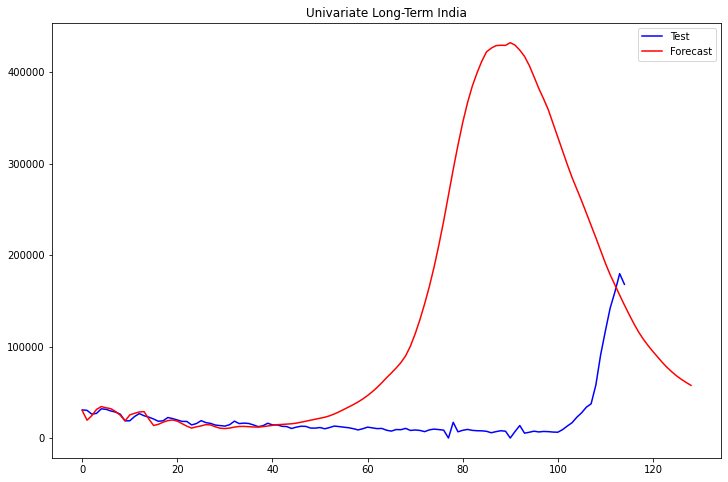

In [67]:
evaluate.plot_fore_test(india_uni_test_np_denorm[timesteps:], yhat_uni_india_denorm, 'Univariate Long-Term India')

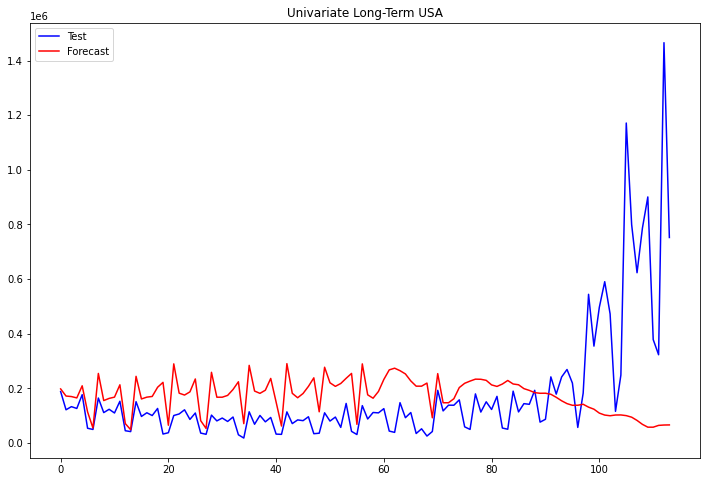

In [68]:
evaluate.plot_fore_test(usa_uni_test_np_denorm[timesteps:], yhat_uni_usa_denorm, 'Univariate Long-Term USA')

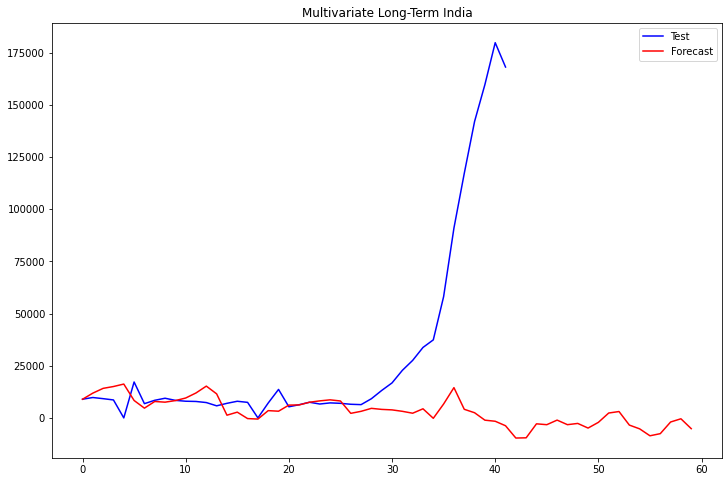

In [69]:
evaluate.plot_fore_test(india_multi_test_np_long_denorm[14:], yhat_multi_india_long_denorm[:60], "Multivariate Long-Term India")

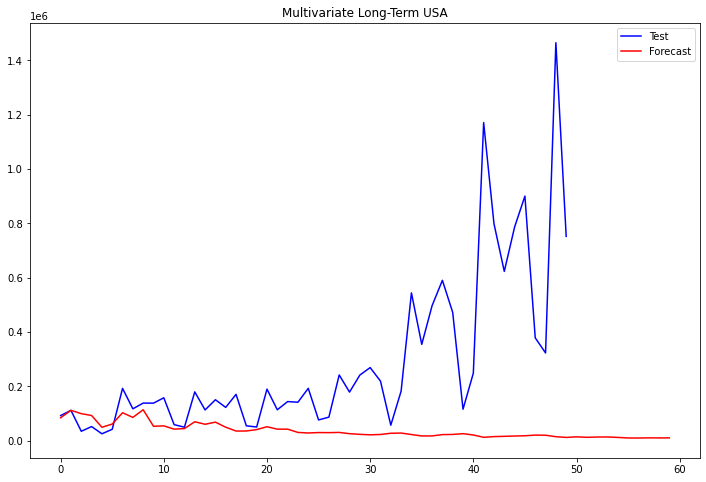

In [70]:
evaluate.plot_fore_test(usa_multi_test_np_long_denorm[14:], yhat_multi_usa_long_denorm[:60], "Multivariate Long-Term USA")

#### Short-Term Rolling Forecast

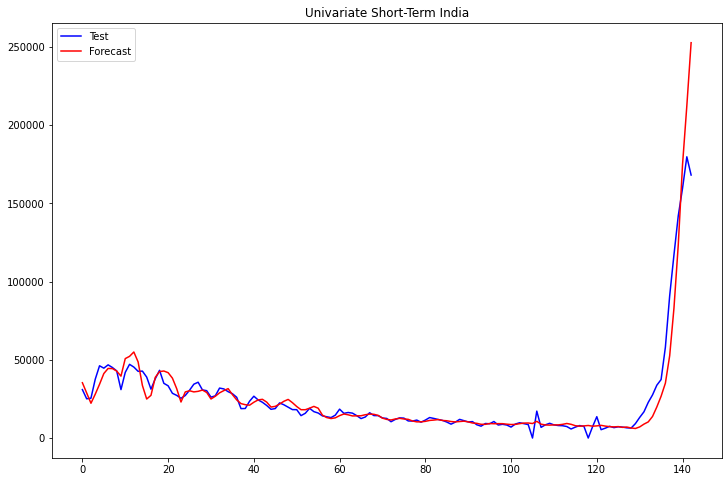

In [71]:
evaluate.plot_fore_test(india_uni_test_short_denorm, yhat_uni_india_short_denorm, "Univariate Short-Term India")

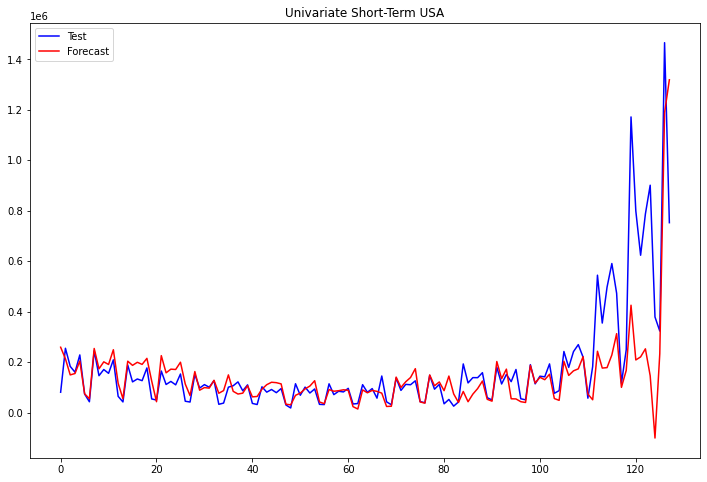

In [72]:
evaluate.plot_fore_test(usa_uni_test_short_denorm, yhat_uni_usa_short_denorm, "Univariate Short-Term USA")

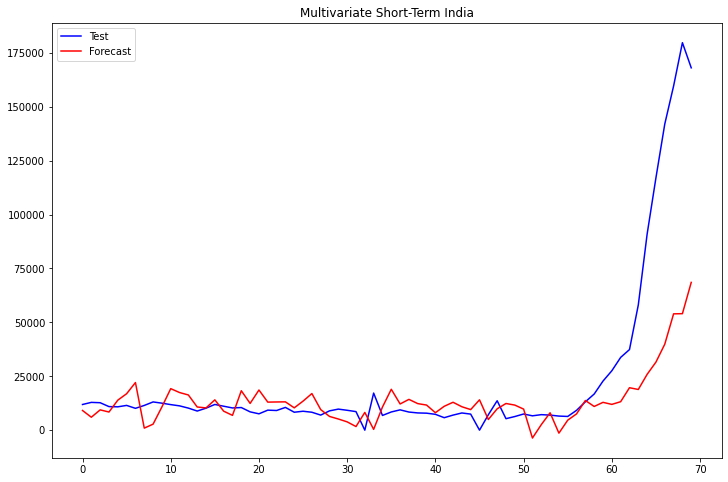

In [73]:
evaluate.plot_fore_test(india_multi_test_np_denorm, yhat_multi_india_denorm[0::2], "Multivariate Short-Term India")

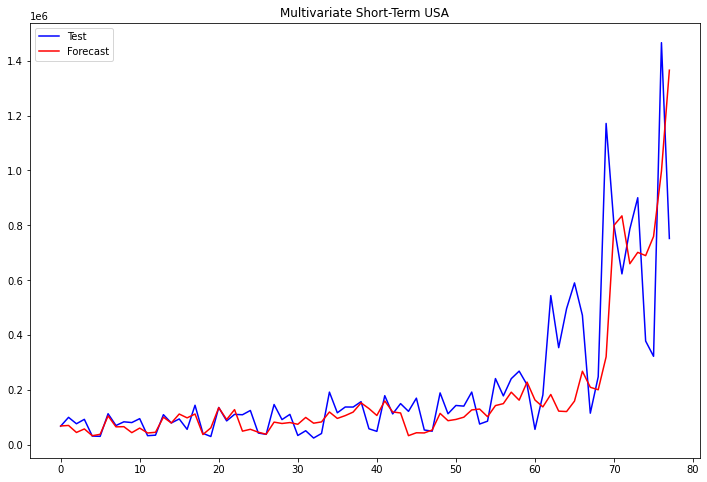

In [74]:
evaluate.plot_fore_test(usa_multi_test_np_denorm, yhat_multi_usa_denorm[0::2], "Multivariate Short-Term USA")